In [68]:

%load_ext autoreload
%autoreload 2
from src.catalogs import (
    JapanSlowSlipCatalog,
    RoussetSlowSlipCatalog, 
    XieSlowSlipCatalog,
    WilliamsSlowSlipCatalog,
    MichelSlowSlipCatalog 
)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy

mpl.rc('figure',dpi=200)
mpl.rc('font',size=8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
slowslip = [
    catalog() for catalog in [
        JapanSlowSlipCatalog,
        RoussetSlowSlipCatalog, 
        XieSlowSlipCatalog,
        WilliamsSlowSlipCatalog,
        MichelSlowSlipCatalog
    ]
]

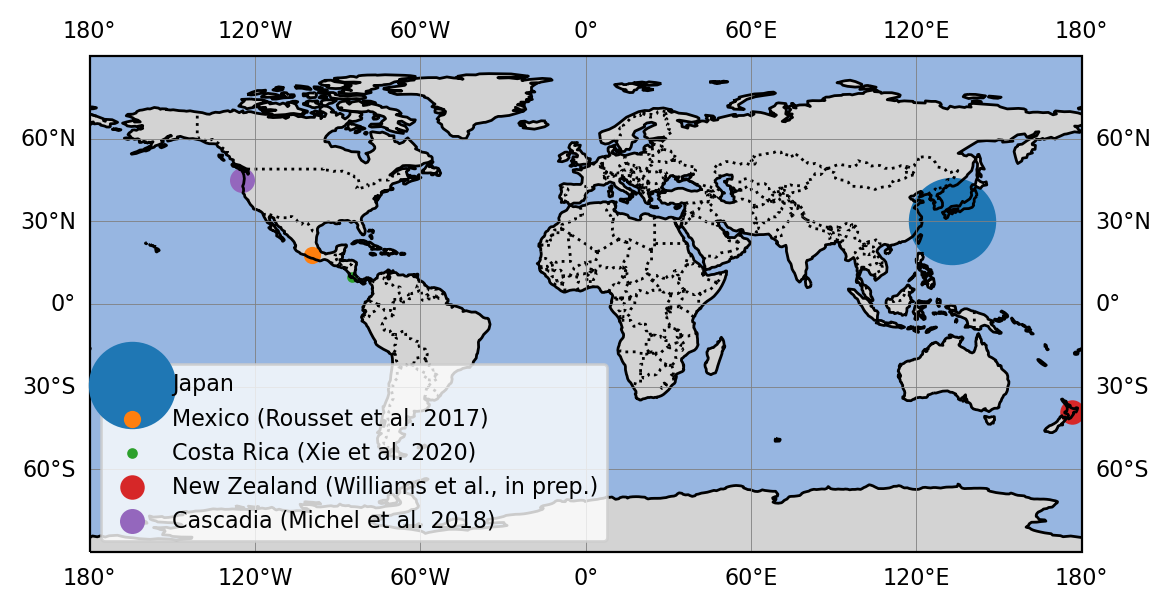

In [69]:

_, ax = plt.subplots(subplot_kw={"projection": cartopy.crs.PlateCarree()})
usemap_proj = cartopy.crs.PlateCarree()
# set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
extent = [-180,180,-90,90]

ax.set_extent(
    extent,
    crs=cartopy.crs.PlateCarree(),
)

ax.add_feature(cartopy.feature.LAND, color="lightgray")
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":")

# plot grid lines
ax.gridlines(draw_labels=True, crs=usemap_proj, color="gray", linewidth=0.3)

for i_slowslip in slowslip:
    ax.scatter(
        np.mean(i_slowslip.longitude_range),
        np.mean(i_slowslip.latitude_range),
        s=len(i_slowslip),
        label=i_slowslip.name,
    )

ax.legend(loc='lower left')

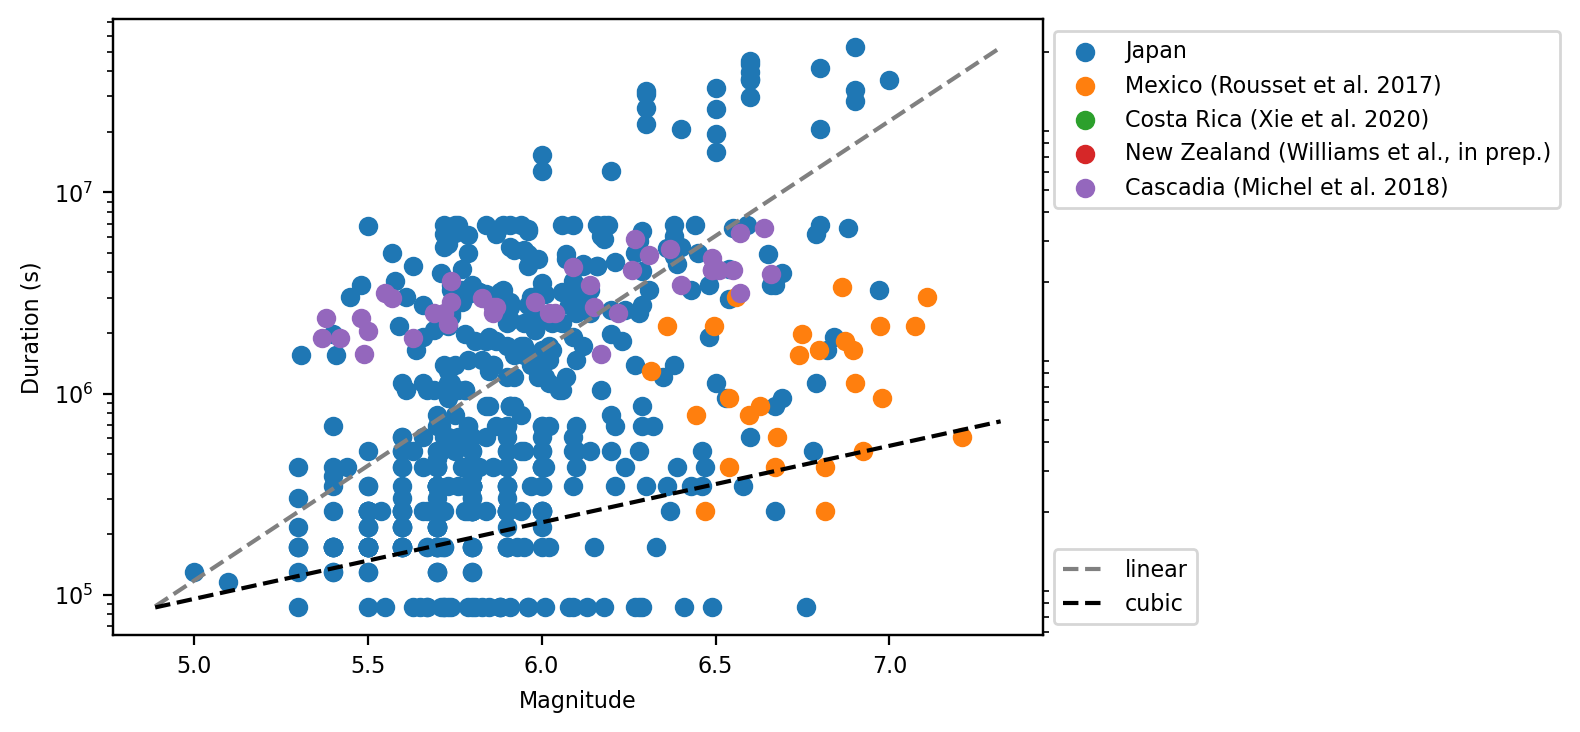

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i_slowslip in slowslip:
    ax.scatter(
        i_slowslip.catalog['mag'],
        i_slowslip.catalog['duration'],
        label=i_slowslip.name,
    )
ax.set(
    xlabel='Magnitude',
    ylabel='Duration (s)',
    yscale='log',
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
xlim = np.array(ax.get_xlim())
axb = ax.twinx()
axb.plot(xlim, 10**xlim, '--', c='grey', label='linear')
axb.plot(xlim, 10**(0.666*xlim[0])*10**(0.333*xlim), '--', c='k', label='cubic')
axb.set(
    yscale='log',
    yticks=[],
)
axb.legend(loc='lower left', bbox_to_anchor=(1,0))


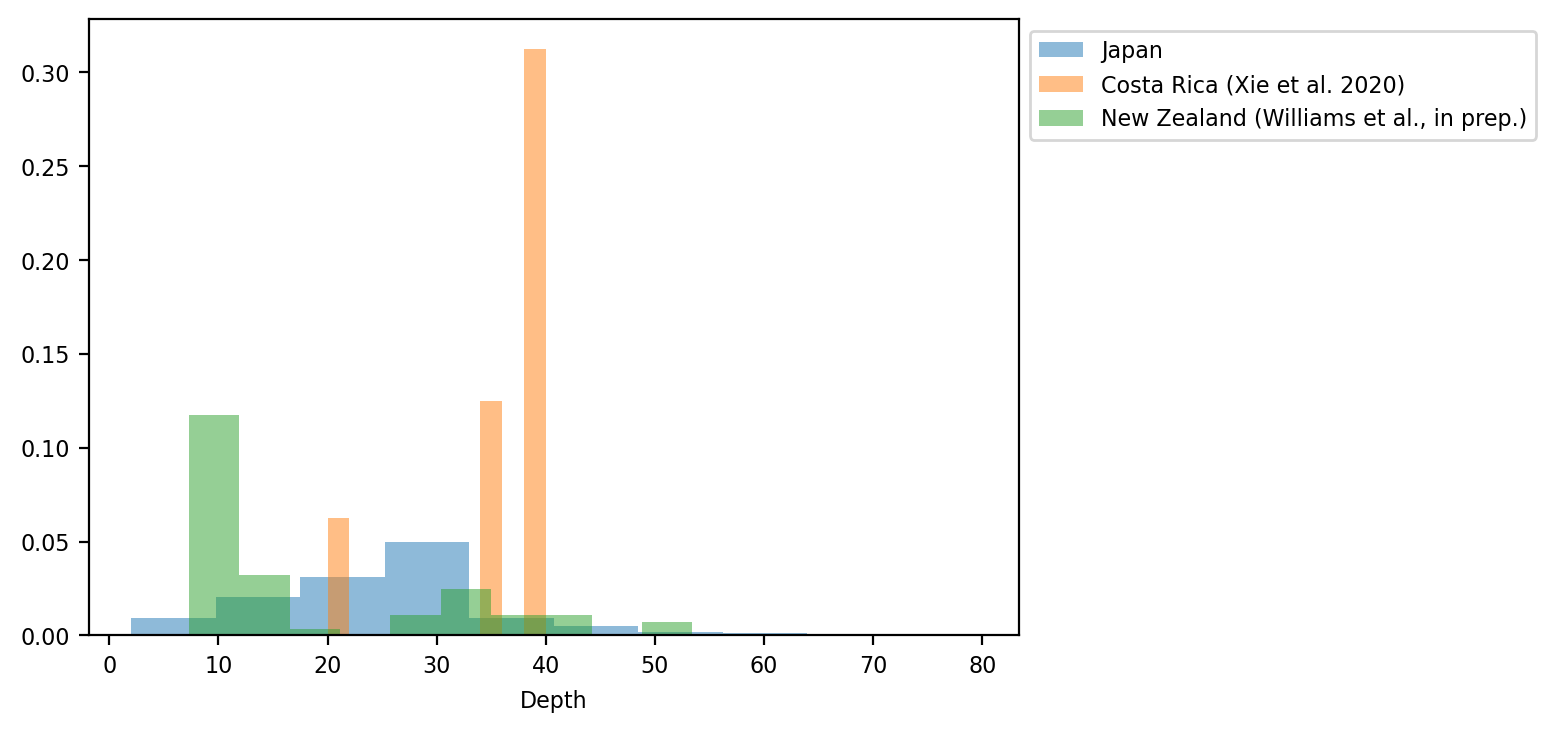

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i_slowslip in slowslip:
    if 'depth' in i_slowslip.catalog.columns:
        ax.hist(
            i_slowslip.catalog['depth'],
            density=True,
            label=i_slowslip.name,
            alpha=0.5
        )
ax.set(
    xlabel='Depth',
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

